# Part 2 – Data Preprocessing, Advanced EDA and Model Comparison

In this part, we will preprocess the data and perform advanced exploratory data analysis (EDA).

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### EDA and Preprocessing
We will analyze missing values, descriptive statistics, distributions, outliers, correlations, and preprocess the dataset.

In [3]:
# Load the dataset and show the first 5 rows before selecting columns
raw_df = pd.read_csv("dataset/Real_Estate_Sales_2001-2022_GL.csv", low_memory=False)
print("Raw Data Sample (first 5 rows):")
display(raw_df.head(5))

Raw Data Sample (first 5 rows):


,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.5354,Residential,Single Family,NaN,NaN,NaN,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.4606,Residential,Three Family,NaN,NaN,NaN,NaN
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.6291,Residential,Two Family,NaN,NaN,NaN,NaN
4,210288,2021,06/20/2022,Avon,12 BYRON DRIVE,179990.0,362500.0,0.4965,Residential,Condo,NaN,NaN,NaN,POINT (-72.879115982 41.773452988)


In [4]:
def missing_values_table(df):
    mis_val = raw_df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(raw_df)
    table = pd.DataFrame({'Missing Values': mis_val, 'Percent': mis_val_percent})
    return table[table['Missing Values'] > 0].sort_values('Percent', ascending=False)

print("Missing values in the raw dataset:")
display(missing_values_table(raw_df))

Missing values in the raw dataset:


,Missing Values,Percent
OPM remarks,1084598,98.812805
Assessor Remarks,926401,84.400194
Location,799518,72.840459
Non Use Code,784178,71.442901
Residential Type,398389,36.295415
Property Type,382446,34.842921
Address,51,0.004646
Date Recorded,2,0.000182


#### Looking at the missing values, we can clearly filter out the OPM remarks, Assessor Remarks, Location, and Non Use Code columns.
The residential type and property type missing in such a large quantity is concerning as it would be useful data for our model. We should look at these missing values.

In [5]:
# Select relevant columns
selected_columns = [
    "List Year",        # numeric (int)
    "Date Recorded",    # categoric (str)
    "Town",             # categoric (str)
    "Address",          # categoric (str)
    "Assessed Value",   # numeric (int)
    "Sale Amount",      # numeric (int) - target
    "Property Type",    # categoric (str)
    "Residential Type"  # categoric (str)
]

In [6]:
df = raw_df[selected_columns]
df = df.dropna(subset=["Sale Amount"])  # eliminate rows with NaN in 'Sale Amount'
print("Selected Columns Sample (first 5 rows):")
display(df.head(5))

# Print the first 5 rows where 'Property Type' is missing
missing_property_type = df[df['Property Type'].isnull()]
print("Rows with missing Property Type (first 5):")
display(missing_property_type.head(5))

Selected Columns Sample (first 5 rows):


,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Property Type,Residential Type
0,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,Residential,Single Family
1,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,Residential,Three Family
2,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,Commercial,NaN
3,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,Residential,Two Family
4,2021,06/20/2022,Avon,12 BYRON DRIVE,179990.0,362500.0,Residential,Condo


Rows with missing Property Type (first 5):


,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Property Type,Residential Type
326,2001,01/10/2002,Danbury,166 OLD BROOKFIELD RD,81100.0,180000.0,NaN,NaN
327,2001,08/16/2002,Guilford,6 LAUREL RDG,187530.0,386500.0,NaN,NaN
332,2001,02/27/2002,Bethel,211 LEXINGTON BLVD,47600.0,109900.0,NaN,NaN
335,2001,06/18/2002,Hampton,741 POMFRET RD,60260.0,145500.0,NaN,NaN
337,2001,01/02/2002,Branford,28 SUNDANCE,42210.0,65900.0,NaN,NaN


#### We should plot the number of missing fields with time as that might give us a hint as to why this is happening.

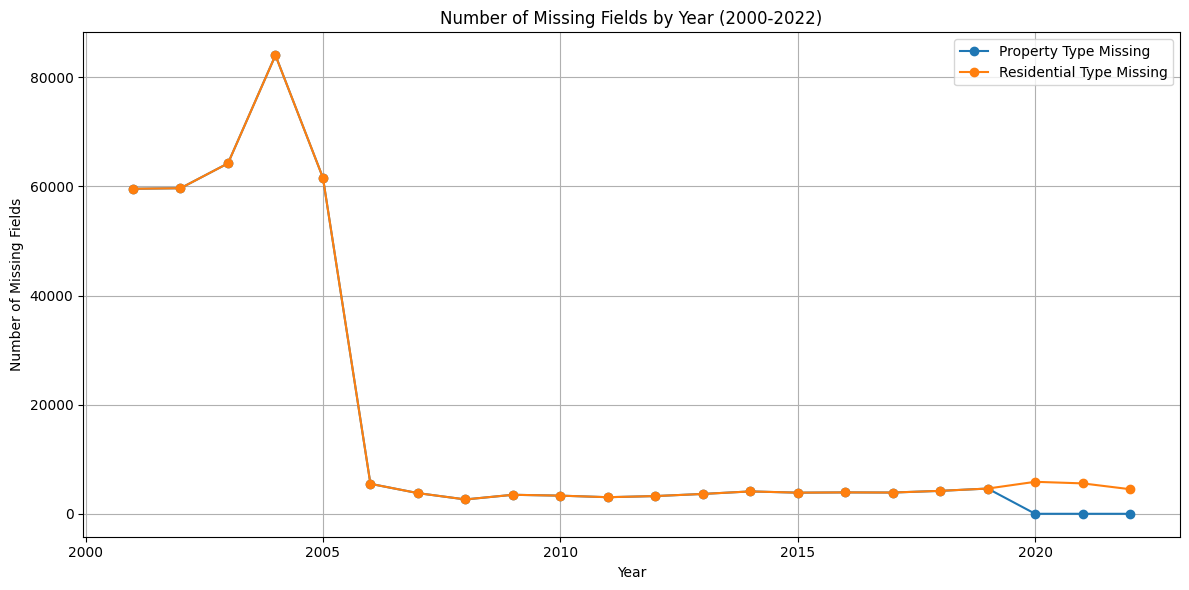

In [7]:
# Plot the number of missing 'Property Type' and 'Residential Type' fields by year (2000-2022)
missing_by_year = df.copy()
missing_by_year['Property Type Missing'] = missing_by_year['Property Type'].isnull()
missing_by_year['Residential Type Missing'] = missing_by_year['Residential Type'].isnull()

missing_counts = missing_by_year.groupby('List Year')[['Property Type Missing', 'Residential Type Missing']].sum()

plt.figure(figsize=(12, 6))
plt.plot(missing_counts.index, missing_counts['Property Type Missing'], label='Property Type Missing', marker='o')
plt.plot(missing_counts.index, missing_counts['Residential Type Missing'], label='Residential Type Missing', marker='o')
plt.title('Number of Missing Fields by Year (2000-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Missing Fields')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Missing fields are predominantly before 2006/2007 so we might get better results by removing all fields with a missing property type

In [8]:
# Remove all rows with a missing 'Property Type' and reset the index
print(f"Rows before removing missing 'Property Type': {len(df)}")
df = df[df['Property Type'].notnull()].copy()
df.reset_index(drop=True, inplace=True)
print(f"Rows after removing missing 'Property Type': {len(df)}")
# Show updated missing values table for the filtered DataFrame
def missing_values_table_local(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    table = pd.DataFrame({'Missing Values': mis_val, 'Percent': mis_val_percent})
    return table[table['Missing Values'] > 0].sort_values('Percent', ascending=False)
display(missing_values_table_local(df))

Rows before removing missing 'Property Type': 1097629
Rows after removing missing 'Property Type': 715183


,Missing Values,Percent
Residential Type,15943,2.229220
Address,4,0.000559


#### We lost quite a bit of data, but our dataset should be cleaner. We cannot remove missing residential types as they are due to the commercial/vacant land property type. This won't be an issue as we will be one-hot encoding these columns. Next we should check out the statistics of our columns.

In [9]:
# Show descriptive statistics for the cleaned dataset
display(df.describe(include='all'))

,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Property Type,Residential Type
count,715183.000000,715183,715183,715179,7.151830e+05,7.151830e+05,715183,699240
unique,NaN,5159,170,548185,NaN,NaN,11,5
top,NaN,07/01/2019,Bridgeport,8 SOUTH RD,NaN,NaN,Single Family,Single Family
freq,NaN,542,22221,79,NaN,NaN,401612,508044
mean,2014.855875,NaN,NaN,NaN,2.633376e+05,4.009725e+05,NaN,NaN
std,4.938425,NaN,NaN,NaN,1.368058e+06,6.055746e+06,NaN,NaN
min,2006.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN
25%,2011.000000,NaN,NaN,NaN,1.097600e+05,1.550000e+05,NaN,NaN
50%,2015.000000,NaN,NaN,NaN,1.597000e+05,2.450000e+05,NaN,NaN
75%,2019.000000,NaN,NaN,NaN,2.492700e+05,3.899000e+05,NaN,NaN


#### Both the address and date recorded are unhelpful to us so we will remove those columns.

In [10]:
selected_columns = [
    "List Year",        # numeric (int)
    "Town",             # categoric (str)
    "Assessed Value",   # numeric (int)
    "Sale Amount",      # numeric (int) - target
    "Property Type",    # categoric (str)
    "Residential Type"  # categoric (str)
]
df = df[selected_columns]
display(df.head(5))

,List Year,Town,Assessed Value,Sale Amount,Property Type,Residential Type
0,2020,Ansonia,133000.0,248400.0,Residential,Single Family
1,2020,Ansonia,110500.0,239900.0,Residential,Three Family
2,2020,Ansonia,150500.0,325000.0,Commercial,NaN
3,2020,Ansonia,127400.0,202500.0,Residential,Two Family
4,2021,Avon,179990.0,362500.0,Residential,Condo


## We will plot our Assesed Value and Sale Amount to see how they vary with time

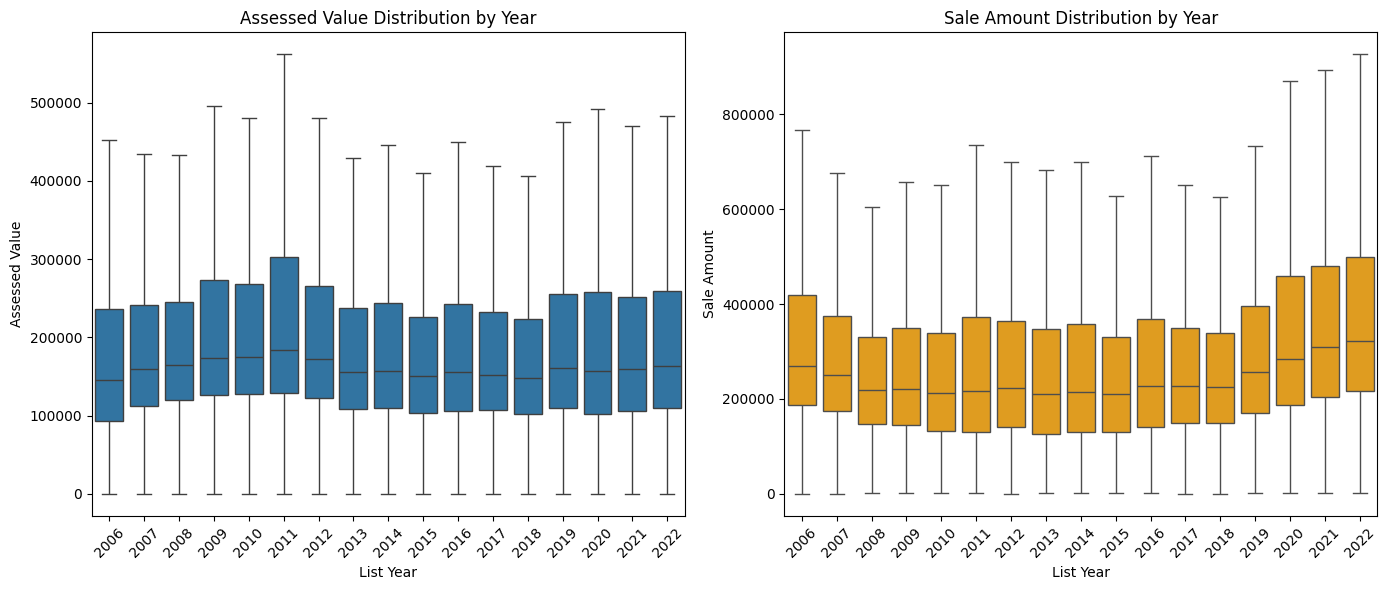

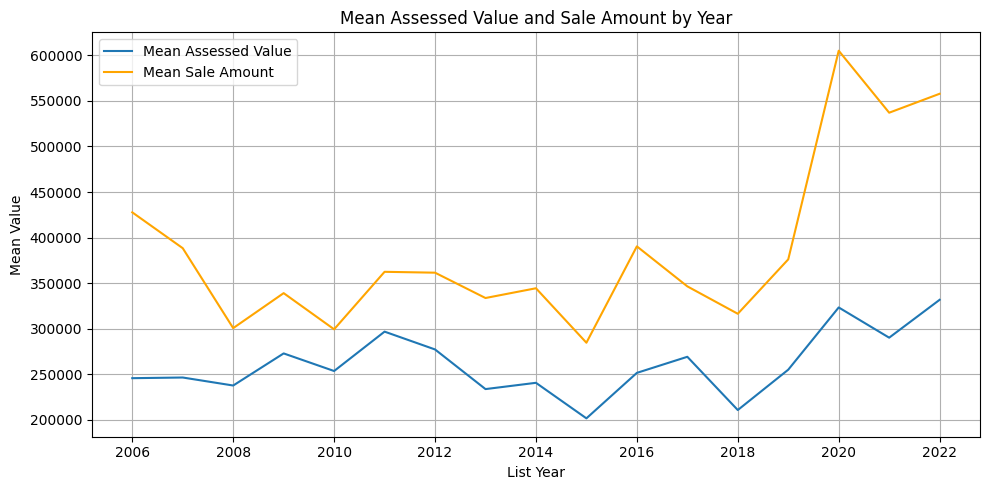

In [11]:
# Plot Assessed Value and Sale Amount by List Year as boxplots and lineplots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x="List Year", y="Assessed Value", data=df, showfliers=False)
plt.title("Assessed Value Distribution by Year")
plt.xlabel("List Year")
plt.ylabel("Assessed Value")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x="List Year", y="Sale Amount", data=df, showfliers=False, color="orange")
plt.title("Sale Amount Distribution by Year")
plt.xlabel("List Year")
plt.ylabel("Sale Amount")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Also show mean values as lineplots for additional insight
plt.figure(figsize=(10, 5))
df_grouped = df.groupby("List Year").agg({"Assessed Value": "mean", "Sale Amount": "mean"})
plt.plot(df_grouped.index, df_grouped["Assessed Value"], label="Mean Assessed Value")
plt.plot(df_grouped.index, df_grouped["Sale Amount"], label="Mean Sale Amount", color="orange")
plt.title("Mean Assessed Value and Sale Amount by Year")
plt.xlabel("List Year")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### We have extreme variance and a lot of outliers.
We will try log transforming both of these columns to see if that helps.

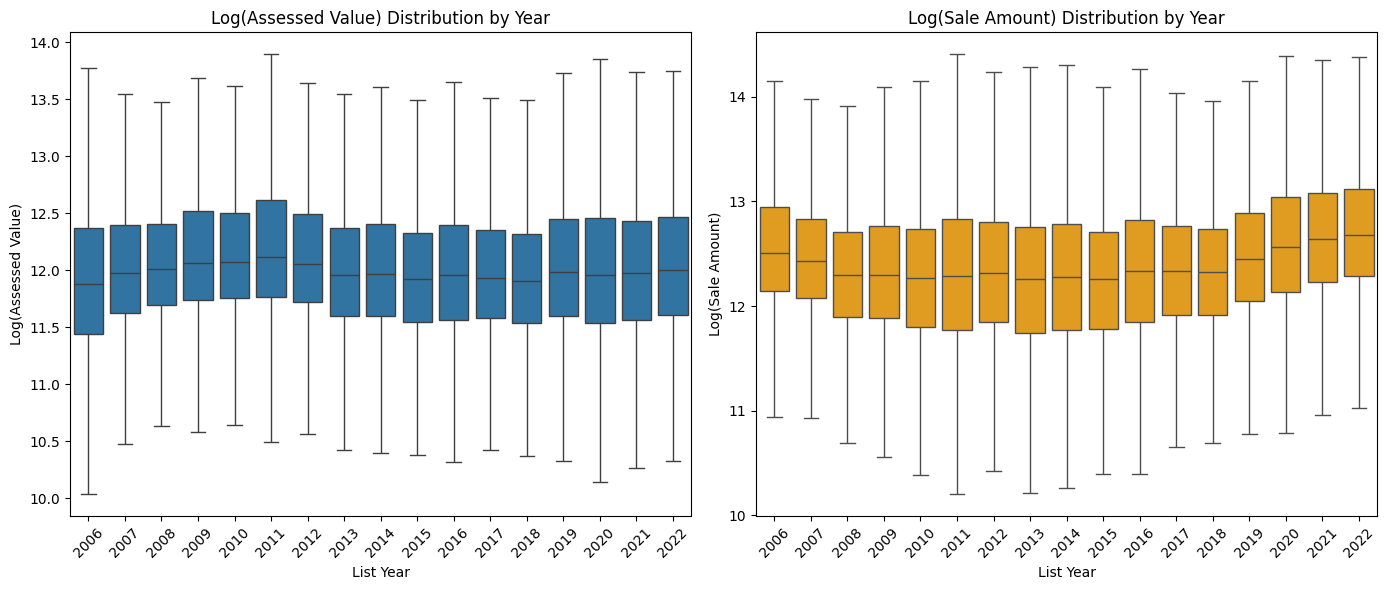

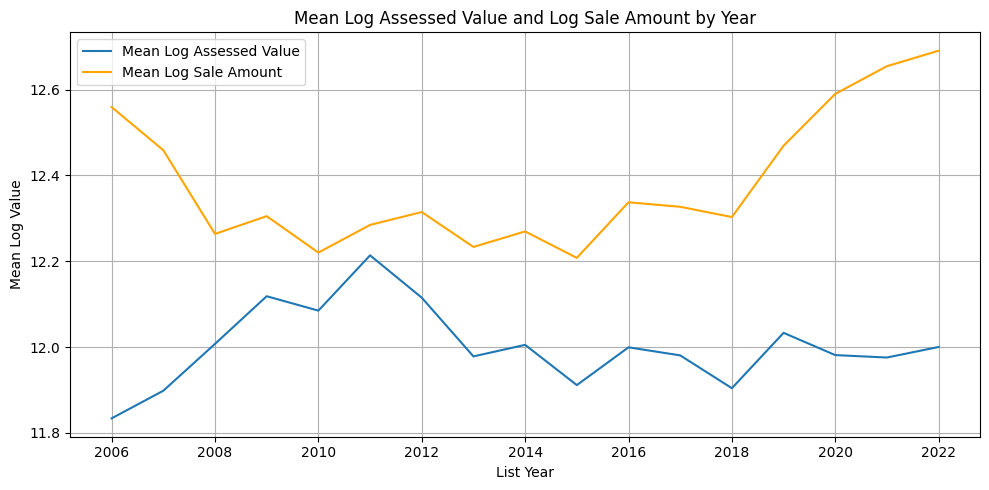

In [12]:
# Log-transform Assessed Value and Sale Amount
df['Log Assessed Value'] = np.log1p(df['Assessed Value'])
df['Log Sale Amount'] = np.log1p(df['Sale Amount'])

# Plot boxplots of log-transformed values by year
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x="List Year", y="Log Assessed Value", data=df, showfliers=False)
plt.title("Log(Assessed Value) Distribution by Year")
plt.xlabel("List Year")
plt.ylabel("Log(Assessed Value)")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x="List Year", y="Log Sale Amount", data=df, showfliers=False, color="orange")
plt.title("Log(Sale Amount) Distribution by Year")
plt.xlabel("List Year")
plt.ylabel("Log(Sale Amount)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Plot mean log values as lineplots
plt.figure(figsize=(10, 5))
df_grouped_log = df.groupby("List Year").agg({"Log Assessed Value": "mean", "Log Sale Amount": "mean"})
plt.plot(df_grouped_log.index, df_grouped_log["Log Assessed Value"], label="Mean Log Assessed Value")
plt.plot(df_grouped_log.index, df_grouped_log["Log Sale Amount"], label="Mean Log Sale Amount", color="orange")
plt.title("Mean Log Assessed Value and Log Sale Amount by Year")
plt.xlabel("List Year")
plt.ylabel("Mean Log Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Log Transformation Effects
Applying the natural logarithm to Assessed Value and Sale Amount reduces the impact of extreme outliers and compresses the range of values. This makes the distributions more symmetric and closer to normal. The boxplots above show that the spread of values is reduced and the presence of extreme values is less pronounced. The line plots of mean log values by year reveal smoother trends, making it easier to compare changes over time.

## Categorical Feature Distributions
We will visualize the distributions of the main categorical features: Town, Property Type, and Residential Type. This helps us understand the frequency of each category, spot rare categories, and identify potential grouping or encoding needs.

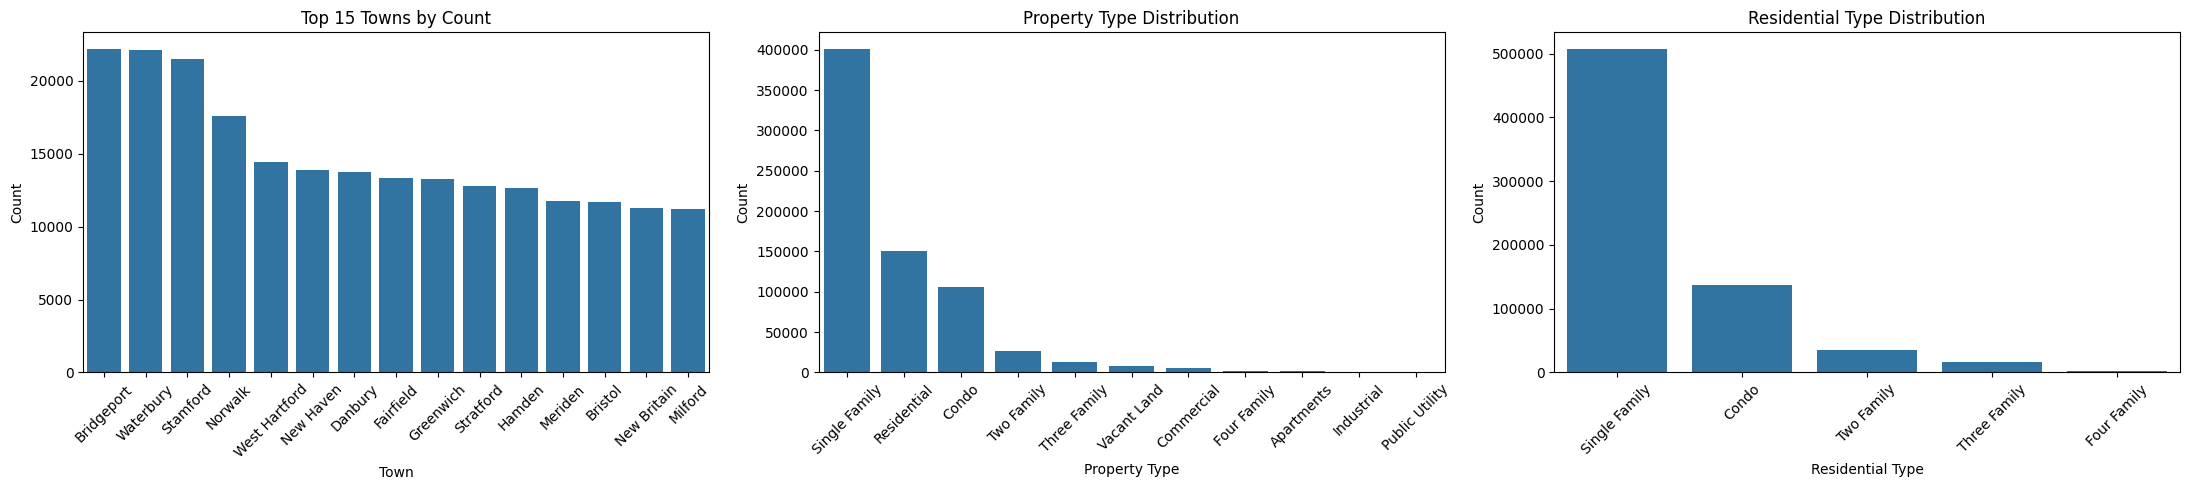

In [13]:
# Plot the distribution of categorical features
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

sns.countplot(ax=axes[0], x=df['Town'], order=df['Town'].value_counts().index[:15])
axes[0].set_title('Top 15 Towns by Count')
axes[0].set_xlabel('Town')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[1], x=df['Property Type'], order=df['Property Type'].value_counts().index)
axes[1].set_title('Property Type Distribution')
axes[1].set_xlabel('Property Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[2], x=df['Residential Type'], order=df['Residential Type'].value_counts().index)
axes[2].set_title('Residential Type Distribution')
axes[2].set_xlabel('Residential Type')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Looking at this we can identify groupings with a very small number of occurences and that the residential type does not help us because the property type already tells us that information.

## Correlation Analysis
Next, we will compute and visualize the correlation matrix for the numeric features, including the log-transformed columns. This helps us identify relationships between variables and potential multicollinearity issues.

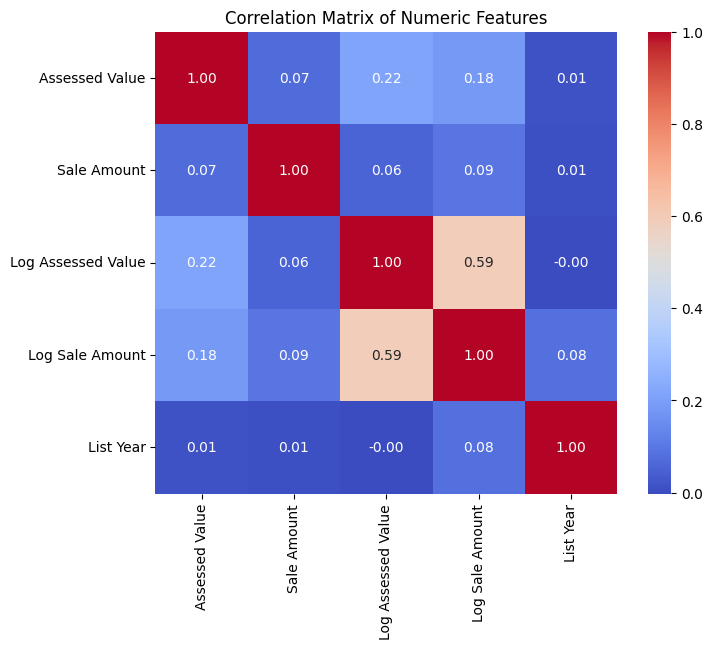

,List Year,Town,Assessed Value,Sale Amount,Property Type,Residential Type,Log Assessed Value,Log Sale Amount
0,2020,Ansonia,133000.0,248400.0,Residential,Single Family,11.798112,12.422800
1,2020,Ansonia,110500.0,239900.0,Residential,Three Family,11.612780,12.387982
2,2020,Ansonia,150500.0,325000.0,Commercial,NaN,11.921725,12.691584
3,2020,Ansonia,127400.0,202500.0,Residential,Two Family,11.755095,12.218500
4,2021,Avon,179990.0,362500.0,Residential,Condo,12.100662,12.800783


In [14]:
# Compute and plot the correlation matrix for numeric features
numeric_cols = ['Assessed Value', 'Sale Amount', 'Log Assessed Value', 'Log Sale Amount', 'List Year']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()
display(df.head())

#### Looking at this heatmap, going with log transforming our prices seems to have greatly helped and we can safely remove the columns without the log transform.

In [15]:
selected_columns = [
    "List Year",            # numeric (int)
    "Town",                 # categoric (str)
    "Log Assessed Value",   # numeric (int)
    "Log Sale Amount",      # numeric (int) - target
    "Property Type",        # categoric (str)
    "Residential Type"      # categoric (str)
]
display(df.head(5))

,List Year,Town,Assessed Value,Sale Amount,Property Type,Residential Type,Log Assessed Value,Log Sale Amount
0,2020,Ansonia,133000.0,248400.0,Residential,Single Family,11.798112,12.422800
1,2020,Ansonia,110500.0,239900.0,Residential,Three Family,11.612780,12.387982
2,2020,Ansonia,150500.0,325000.0,Commercial,NaN,11.921725,12.691584
3,2020,Ansonia,127400.0,202500.0,Residential,Two Family,11.755095,12.218500
4,2021,Avon,179990.0,362500.0,Residential,Condo,12.100662,12.800783


#### Looking at the graphs higher up, it seems like the Residential Property Type might be useless.

In [16]:
# Show the first 5 rows where Property Type is 'Residential'
display(df[df['Property Type'] == 'Residential'].head())

# Show the first 5 rows where Property Type is 'Condo'
display(df[df['Property Type'] == 'Condo'].head())

,List Year,Town,Assessed Value,Sale Amount,Property Type,Residential Type,Log Assessed Value,Log Sale Amount
0,2020,Ansonia,133000.0,248400.0,Residential,Single Family,11.798112,12.422800
1,2020,Ansonia,110500.0,239900.0,Residential,Three Family,11.612780,12.387982
3,2020,Ansonia,127400.0,202500.0,Residential,Two Family,11.755095,12.218500
4,2021,Avon,179990.0,362500.0,Residential,Condo,12.100662,12.800783
5,2020,Avon,217640.0,400000.0,Residential,Single Family,12.290602,12.899222


,List Year,Town,Assessed Value,Sale Amount,Property Type,Residential Type,Log Assessed Value,Log Sale Amount
123537,2006,Branford,138400.0,203300.0,Condo,Condo,11.837911,12.222443
123538,2006,Cromwell,43260.0,106000.0,Condo,Condo,10.675007,11.571204
123539,2006,Bristol,56410.0,158000.0,Condo,Condo,10.940419,11.970357
123540,2006,Glastonbury,84000.0,174000.0,Condo,Condo,11.338584,12.066816
123541,2006,Newington,118510.0,187000.0,Condo,Condo,11.682761,12.138869


#### This confirms that when we meet the Residential Property Type we can just use the Residential Type and remove the Residential Type column.

,List Year,Town,Log Assessed Value,Log Sale Amount,Property Type
0,2020,Ansonia,11.798112,12.422800,Single Family
1,2020,Ansonia,11.612780,12.387982,Three Family
2,2020,Ansonia,11.921725,12.691584,Commercial
3,2020,Ansonia,11.755095,12.218500,Two Family
4,2021,Avon,12.100662,12.800783,Condo
5,2020,Avon,12.290602,12.899222,Single Family
6,2020,Avon,13.177781,13.560620,Single Family
7,2020,Barkhamsted,12.223574,12.936036,Single Family
8,2020,Beacon Falls,11.970546,12.400821,Single Family
9,2020,Beacon Falls,11.091194,11.512935,Condo


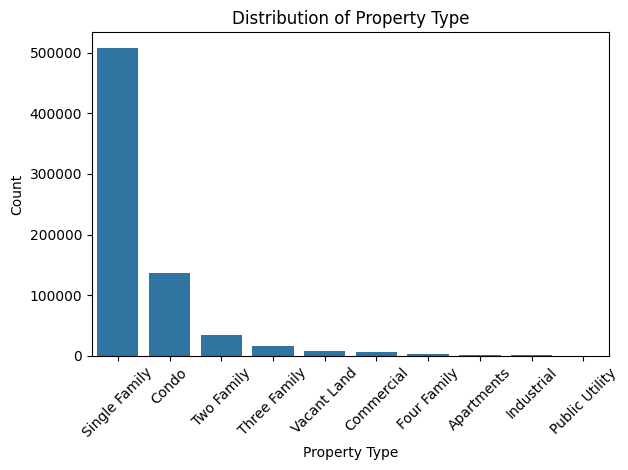

In [17]:
# Replace 'Residential' in Property Type with the value from Residential Type
mask = df['Property Type'] == 'Residential'
df.loc[mask, 'Property Type'] = df.loc[mask, 'Residential Type']
selected_columns = [
    "List Year",            # numeric (int)
    "Town",                 # categoric (str)
    "Log Assessed Value",   # numeric (int)
    "Log Sale Amount",      # numeric (int) - target
    "Property Type",        # categoric (str)
]
df = df[selected_columns]
# Show the first few rows to confirm the change
display(df.head(10))
# Plot the distribution of Property Type
sns.countplot(x='Property Type', data=df, order=df['Property Type'].value_counts().index)
plt.title('Distribution of Property Type')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Outlier Detection with Boxplot and IQR
We will visualize outliers in the main numeric features using boxplots, and then use the Interquartile Range (IQR) method to detect and count outliers for each feature. This helps us understand the extent of extreme values and decide on further preprocessing steps.

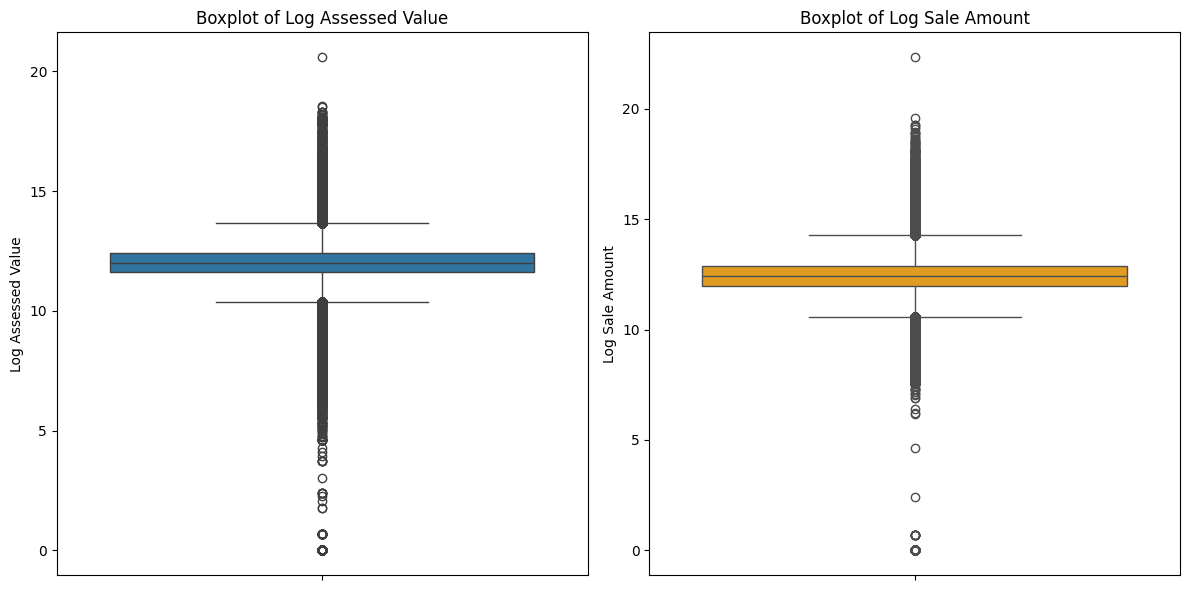

In [18]:
# Visualize outliers with boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Log Assessed Value'])
plt.title('Boxplot of Log Assessed Value')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Log Sale Amount'], color='orange')
plt.title('Boxplot of Log Sale Amount')
plt.tight_layout()
plt.show()

#### Remove Outliers Based on IQR
We will remove rows where the log-transformed numeric features are outside the IQR bounds.

In [19]:
# Remove outliers for Log Assessed Value and Log Sale Amount using IQR
print(f"Rows before removing outliers: {len(df)}")
for col in ['Log Assessed Value', 'Log Sale Amount']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# Show the shape and a sample after outlier removal
print(f"Rows after removing outliers: {len(df)}")
display(df.head())

Rows before removing outliers: 715183
Rows after removing outliers: 649503


,List Year,Town,Log Assessed Value,Log Sale Amount,Property Type
0,2020,Ansonia,11.798112,12.422800,Single Family
1,2020,Ansonia,11.612780,12.387982,Three Family
2,2020,Ansonia,11.921725,12.691584,Commercial
3,2020,Ansonia,11.755095,12.218500,Two Family
4,2021,Avon,12.100662,12.800783,Condo


### One-Hot Encode Top 15 Towns and Remove Others
We will keep only the rows where the 'Town' is one of the 15 most frequent towns, then one-hot encode the 'Town' column.

In [20]:
TOP_N = 15
top_towns = df['Town'].value_counts().index[:TOP_N]

# Filter the DataFrame to only include rows with top 15 towns
df_top_towns = df[df['Town'].isin(top_towns)].copy()

# One-hot encode the 'Town' column
town_dummies = pd.get_dummies(df_top_towns['Town'], prefix='Town')
df_top_towns = pd.concat([df_top_towns.drop('Town', axis=1), town_dummies], axis=1)

display(df_top_towns.head(10))

,List Year,Log Assessed Value,Log Sale Amount,Property Type,Town_Bridgeport,Town_Bristol,Town_Danbury,Town_Fairfield,Town_Hamden,Town_Manchester,Town_Meriden,Town_Milford,Town_New Britain,Town_New Haven,Town_Norwalk,Town_Stamford,Town_Stratford,Town_Waterbury,Town_West Hartford
23,2020,11.678025,12.388398,Single Family,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
24,2021,11.613775,10.819798,Vacant Land,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
25,2020,11.034099,11.774528,Condo,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
26,2020,10.769137,11.512935,Vacant Land,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
27,2020,10.769137,10.712215,Vacant Land,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
28,2020,11.920329,12.528160,Single Family,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
30,2020,11.379406,12.072547,Single Family,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
31,2021,12.437783,13.384729,Commercial,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32,2021,11.168334,11.775297,Condo,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
33,2020,11.535381,12.154785,Two Family,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


### We will do the same thing for the Top 8 Property Types

In [21]:
TOP_N = 8
top_types = df_top_towns['Property Type'].value_counts().index[:TOP_N]

# Filter to only rows with top 8 property types
df_top_types = df_top_towns[df_top_towns['Property Type'].isin(top_types)].copy()

# One-hot encode the 'Property Type' column
type_dummies = pd.get_dummies(df_top_types['Property Type'], prefix='PropertyType')
df_top_types = pd.concat([df_top_types.drop('Property Type', axis=1), type_dummies], axis=1)

display(df_top_types.head(10))

,List Year,Log Assessed Value,Log Sale Amount,Town_Bridgeport,Town_Bristol,Town_Danbury,Town_Fairfield,Town_Hamden,Town_Manchester,Town_Meriden,...,Town_Waterbury,Town_West Hartford,PropertyType_Apartments,PropertyType_Commercial,PropertyType_Condo,PropertyType_Four Family,PropertyType_Single Family,PropertyType_Three Family,PropertyType_Two Family,PropertyType_Vacant Land
23,2020,11.678025,12.388398,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
24,2021,11.613775,10.819798,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
25,2020,11.034099,11.774528,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
26,2020,10.769137,11.512935,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
27,2020,10.769137,10.712215,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
28,2020,11.920329,12.528160,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
30,2020,11.379406,12.072547,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
31,2021,12.437783,13.384729,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
32,2021,11.168334,11.775297,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
33,2020,11.535381,12.154785,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## Prepare the dataset for modelling

In [22]:
# Prepare the dataset for modelling
from sklearn.model_selection import train_test_split

X = df_top_types.drop(columns=['Log Sale Amount'])
y = df_top_types['Log Sale Amount']
# display(X.head(5))
# display(y.head(5))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Linear Regression
#### We will fit a linear regression model to the prepared dataset and evaluate its performance.

Train R^2:   0.686
Test R^2:    0.690
Train RMSE: 0.371
Test RMSE:  0.369


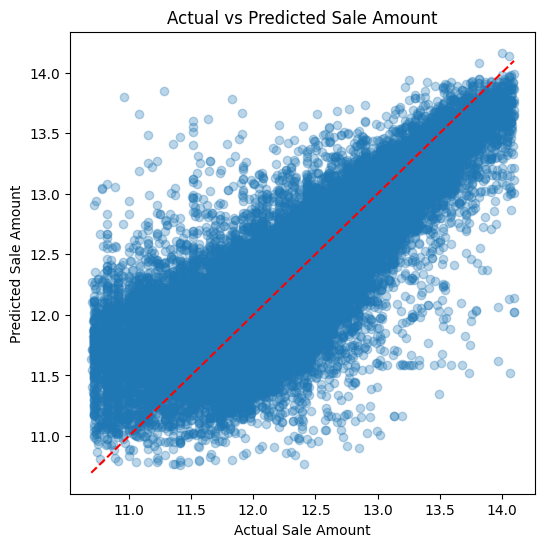

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Initialize and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Predict on train and test sets
y_train_pred = lr.predict(X_train)
y_test_pred  = lr.predict(X_test)

# Calculate R^2
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test,  y_test_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

print(f"Train R^2:   {r2_train:.3f}")
print(f"Test R^2:    {r2_test:.3f}")
print(f"Train RMSE: {rmse_train:.3f}")
print(f"Test RMSE:  {rmse_test:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual Sale Amount")
plt.ylabel("Predicted Sale Amount")
plt.title("Actual vs Predicted Sale Amount")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


### Interpretation for Linear Regression
#### We're off by about +/-44.7% (exp(0.369))

## Random Forest Regressor
#### We will fit a linear regression model to the prepared dataset and evaluate its performance.

RF Train R^2:   0.824
RF Test R^2:    0.796
RF Train RMSE: 0.278
RF Test RMSE:  0.300


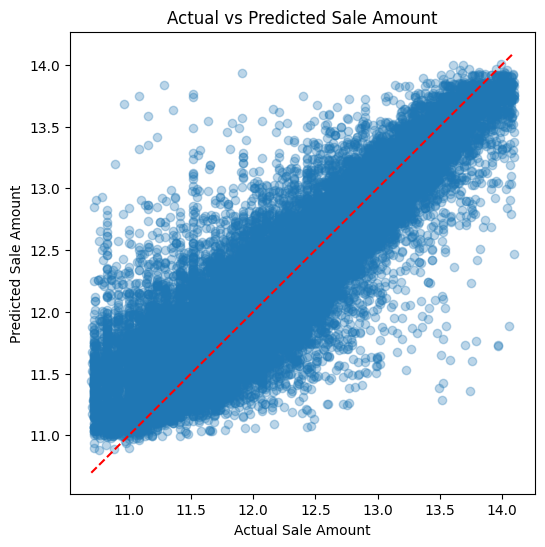

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf = RandomForestRegressor(
    n_estimators=34,    # number of trees
    max_depth=13,      # no limit on depth
    min_samples_leaf=2,  # minimum samples per leaf
    random_state=420,
    n_jobs=-1            # use all CPU cores
)

# Fit to training data
rf.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = rf.predict(X_train)
y_test_pred  = rf.predict(X_test)

# Calculate R^2
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test,  y_test_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

print(f"RF Train R^2:   {r2_train:.3f}")
print(f"RF Test R^2:    {r2_test:.3f}")
print(f"RF Train RMSE: {rmse_train:.3f}")
print(f"RF Test RMSE:  {rmse_test:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual Sale Amount")
plt.ylabel("Predicted Sale Amount")
plt.title("Actual vs Predicted Sale Amount")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


### Interpretation for Random Forest Regressor
#### We're off by about +/-34.9% (exp(0.300))

## History Gradient Boosting Regressor
#### We will fit a HistGradientBoostingRegressor model to the prepared dataset and evaluate its performance.

HGB Train R²:   0.807
HGB Test R²:    0.802
HGB Train RMSE: 0.291
HGB Test RMSE:  0.295


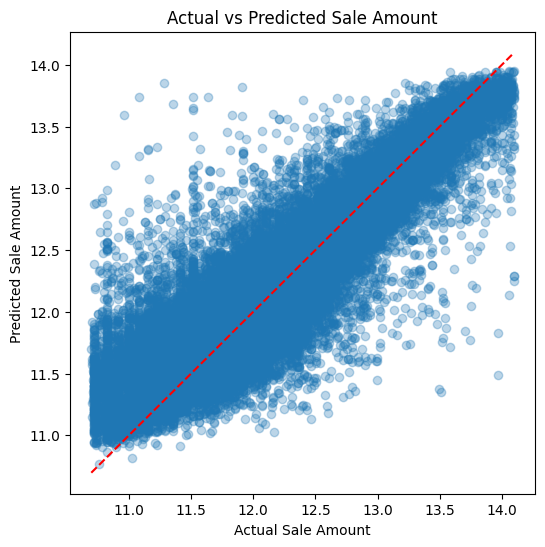

In [27]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Initialize the model
hgb = HistGradientBoostingRegressor(
    loss='squared_error',    # regression objective
    max_iter=1500,            # number of boosting iterations
    learning_rate=0.03,      # shrinkage factor
    max_depth=7,             # tree depth
    max_bins=255,            # number of bins for histogram
    min_samples_leaf=10,     # regularization
    early_stopping=True,     # use 10% of train for validation
    scoring='neg_root_mean_squared_error', 
    random_state=69
)

# Fit to training data
hgb.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = hgb.predict(X_train)
y_test_pred  = hgb.predict(X_test)

# Calculate R²
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test,  y_test_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

print(f"HGB Train R²:   {r2_train:.3f}")
print(f"HGB Test R²:    {r2_test:.3f}")
print(f"HGB Train RMSE: {rmse_train:.3f}")
print(f"HGB Test RMSE:  {rmse_test:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual Sale Amount")
plt.ylabel("Predicted Sale Amount")
plt.title("Actual vs Predicted Sale Amount")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


### Interpretation for Random Forest Regressor
#### We're off by about +/-34.3% (exp(0.295))